In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from collections import Counter
from collections import defaultdict


In [2]:
class_name = 'Occupancy'
df = pd.read_csv('datatraining.txt', skipinitialspace=True, na_values='?', 
                 keep_default_na=True)
print(df.shape)
df.head()

(8143, 7)


,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
1,2015-02-04 17:51:00,23.18,27.2720,426.0,721.25,0.004793,1
2,2015-02-04 17:51:59,23.15,27.2675,429.5,714.00,0.004783,1
3,2015-02-04 17:53:00,23.15,27.2450,426.0,713.50,0.004779,1
4,2015-02-04 17:54:00,23.15,27.2000,426.0,708.25,0.004772,1
5,2015-02-04 17:55:00,23.10,27.2000,426.0,704.50,0.004757,1


In [3]:
del df['date']

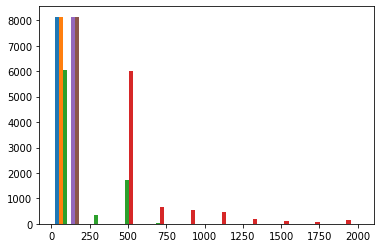

In [4]:
plt.hist(df.values)
plt.show()

In [5]:
def prepare_dataset(df, class_name):
    df = remove_missing_values(df)
    numeric_columns = get_numeric_columns(df)
    rdf = df.copy(deep=True)
    df, feature_names, class_values = one_hot_encoding(df, class_name)
    real_feature_names = get_real_feature_names(rdf, numeric_columns, class_name)
    rdf = rdf[real_feature_names + (class_values if isinstance(class_name, list) else [class_name])]
    features_map = get_features_map(feature_names, real_feature_names)

    return df, feature_names, class_values, numeric_columns, rdf, real_feature_names, features_map

def remove_missing_values(df):
    for column_name, nbr_missing in df.isna().sum().to_dict().items():
        if nbr_missing > 0:
            if column_name in df._get_numeric_data().columns:
                mean = df[column_name].mean()
                df[column_name].fillna(mean, inplace=True)
            else:
                mode = df[column_name].mode().values[0]
                df[column_name].fillna(mode, inplace=True)
    return df

def get_numeric_columns(df):
    numeric_columns = list(df._get_numeric_data().columns)
    return numeric_columns

def get_real_feature_names(rdf, numeric_columns, class_name):
    real_feature_names = [c for c in rdf.columns if c in numeric_columns and c != class_name]
    real_feature_names += [c for c in rdf.columns if c not in numeric_columns and c != class_name]
    return real_feature_names

def one_hot_encoding(df, class_name):
    dfX = pd.get_dummies(df[[c for c in df.columns if c != class_name]], prefix_sep='=')
    class_name_map = {v: k for k, v in enumerate(sorted(df[class_name].unique()))}
    dfY = df[class_name].map(class_name_map)
    df = pd.concat([dfX, dfY], axis=1)
    feature_names = list(dfX.columns)
    class_values = sorted(class_name_map)
    return df, feature_names, class_values

def get_features_map(feature_names, real_feature_names):
    features_map = defaultdict(dict)
    i = 0
    j = 0

    while i < len(feature_names) and j < len(real_feature_names):
        if feature_names[i] == real_feature_names[j]:
            features_map[j][feature_names[i]] = j
            i += 1
            j += 1
        elif feature_names[i].startswith(real_feature_names[j]):
            features_map[j][feature_names[i]] = j
            i += 1
        else:
            j += 1
    return features_map

In [6]:
from sklearn.model_selection import train_test_split, cross_val_score 

from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score
attributes = [col for col in df.columns if col != class_name]
X = df[attributes].values
y = df[class_name]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100, stratify=y)

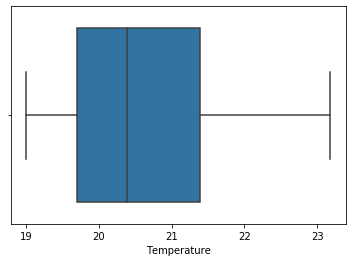

In [23]:
import seaborn as sns
sns.boxplot(df['Temperature'])

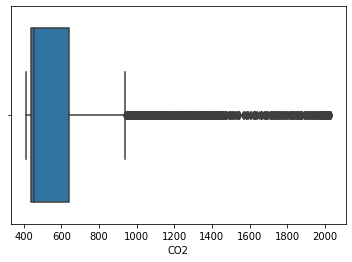

In [24]:
import seaborn as sns
sns.boxplot(df['CO2'])

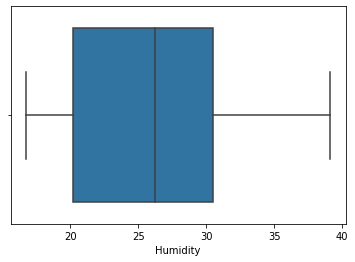

In [25]:
import seaborn as sns
sns.boxplot(df['Humidity'])

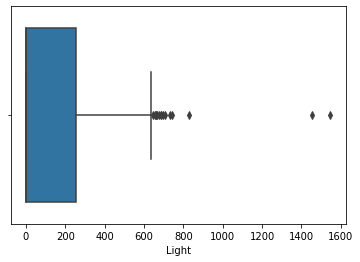

In [26]:
import seaborn as sns
sns.boxplot(df['Light'])

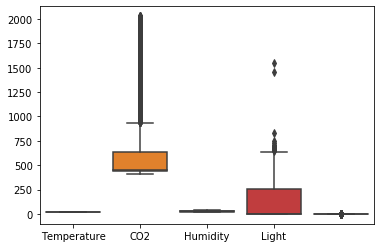

In [27]:
sns.boxplot(data=[X[:,0], X[:,3], X[:,1], X[:,2], X[:,4]])
plt.xticks([0,1,2,3], [attributes[0], attributes[3],attributes[1], attributes[2]])
plt.show()

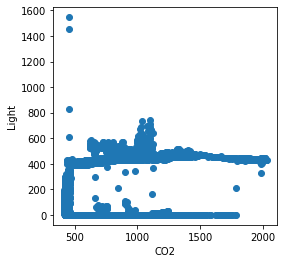

In [28]:
fig, ax = plt.subplots(figsize=(4,4))
ax.scatter(df['CO2'], df['Light'])
ax.set_xlabel('CO2')
ax.set_ylabel('Light')
plt.show()

In [29]:
from scipy import stats
import numpy as np
z = np.abs(stats.zscore(df))
print(z)

[[2.51847007 0.27852622 1.57376283 0.36494808 1.09175697 1.92604745]
 [2.48896731 0.27771261 1.59173515 0.34188106 1.08055497 1.92604745]
 [2.48896731 0.27364453 1.57376283 0.34029023 1.07588816 1.92604745]
 ...
 [0.47294534 1.87375407 1.60970748 0.61073113 2.03352707 1.92604745]
 [0.47294534 1.90358662 1.60970748 0.68019732 2.063811   1.92604745]
 [0.47294534 1.89273842 1.68159679 0.68231843 2.05279837 1.92604745]]


In [30]:
print(z.max())

7.326618984277759


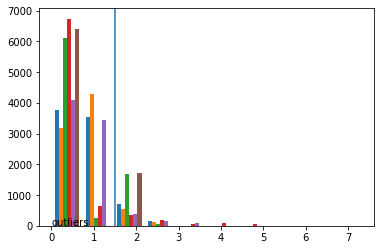

In [31]:
plt.hist(z)
plt.axvline(1.5)
plt.text(0, 7.44, 'outliers')
plt.show()

In [32]:
threshold = 1.5
print(np.where(z > 1.5))

(array([   0,    0,    0, ..., 8142, 8142, 8142], dtype=int64), array([0, 2, 5, ..., 2, 4, 5], dtype=int64))


In [33]:
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.99)
IQR = Q3 - Q1
print(IQR)
print(Q3) #in teoria è il top 1% outliers

Temperature         3.300000
Humidity           18.417500
Light             545.645000
CO2              1511.750000
HumidityRatio       0.003295
Occupancy           1.000000
dtype: float64
Temperature        23.000000
Humidity           38.617500
Light             545.645000
CO2              1950.750000
HumidityRatio       0.006373
Occupancy           1.000000
Name: 0.99, dtype: float64


#### Grubbs'Test

In [34]:
val=df['CO2']

In [35]:
val=val.values

In [36]:
avg_val=np.mean(val)

In [37]:
abs_val=val-avg_val
print(abs_val)

[114.70375681 107.45375681 106.95375681 ... 191.95375681 213.78709014
 214.45375681]


In [38]:
maximum_dev=max(abs_val)
maximum_dev

1421.9537568054361

In [39]:
s=np.std(val)
s

314.30157622237306

In [40]:
Grubs=maximum_dev/s
Grubs

4.5241699831609585

In [41]:
def calculate_critica_val(size, alpha):
    t_dist = stats.t.ppf(1 - alpha / (2 * size), size - 2)
    numerator = (size - 1) * np.sqrt(np.square(t_dist))
    denominator = np.sqrt(size) * np.sqrt(size - 2 + np.square(t_dist))
    critical_value = numerator / denominator
    print("Grubbs Critical Value: {}".format(critical_value))
    return critical_value

In [42]:
calculate_critica_val(len(val),0.05) #critical value< Grub == ci sono out

Grubbs Critical Value: 4.518803261173771


4.518803261173771

#### DBSCAN

In [43]:
from sklearn.cluster import DBSCAN

In [49]:
dbscan = DBSCAN(eps=90, min_samples=20)
dbscan.fit(X)

DBSCAN(algorithm='auto', eps=90, leaf_size=30, metric='euclidean',
       metric_params=None, min_samples=20, n_jobs=None, p=None)

In [50]:
np.unique(dbscan.labels_, return_counts=True)

(array([-1,  0], dtype=int64), array([  29, 8114], dtype=int64))

In [51]:
from sklearn.metrics import silhouette_score
print('Silhouette %s' % silhouette_score(X, dbscan.labels_))

Silhouette 0.6232095435384918


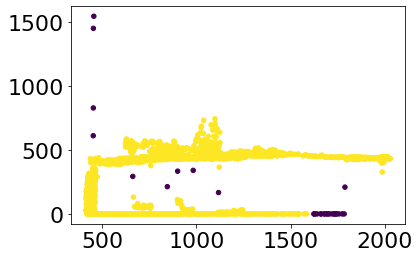

In [52]:
plt.scatter(df['CO2'], df['Light'], c=dbscan.labels_, s=20)
plt.tick_params(axis='both', which='major', labelsize=22)
plt.show()

In [54]:
df.loc[np.where(dbscan.labels_==-1)]

,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
1156,22.840000,25.917500,496.500000,983.000000,0.004460,1
1181,22.290000,26.100000,112.750000,898.500000,0.004343,0
1453,22.075000,23.972500,426.000000,839.000000,0.003934,1
2606,21.290000,19.666667,131.333333,665.333333,0.003072,0
3830,20.700000,18.917500,215.000000,454.500000,0.002849,0
3831,20.700000,18.890000,611.500000,452.250000,0.002845,0
3832,20.700000,18.890000,1546.333333,455.333333,0.002845,0
3833,20.745000,18.890000,1451.750000,453.000000,0.002853,0
6943,21.200000,32.790000,13.000000,1115.500000,0.005111,0
7213,22.066667,37.760000,423.666667,1796.666667,0.006217,1


### LOF

In [55]:
from sklearn.neighbors import LocalOutlierFactor

It is local in that the anomaly score depends on how isolated the object is with respect to the surrounding neighborhood. 

In [56]:
clf = LocalOutlierFactor(n_neighbors=200, algorithm='auto', leaf_size=30, metric='minkowski', p=2, metric_params=None, contamination='auto', novelty=False, n_jobs=None)
outliers = clf.fit_predict(X)

In [57]:
(clf.negative_outlier_factor_).max()

-0.9487946619352029

In [58]:
(clf.negative_outlier_factor_).min()

-13.846408990970382

In [59]:
np.unique(outliers, return_counts=True)

(array([-1,  1]), array([ 501, 7642], dtype=int64))

In [60]:
np.where(outliers==-1)

(array([ 269,  270,  271,  276,  281,  287,  289,  291,  292,  293, 1101,
        1102, 1103, 1104, 1105, 1106, 1107, 1108, 1109, 1110, 1111, 1112,
        1113, 1114, 1115, 1116, 1117, 1118, 1124, 1125, 1126, 1135, 1136,
        1137, 1139, 1140, 1141, 1142, 1143, 1144, 1145, 1146, 1147, 1148,
        1149, 1150, 1151, 1152, 1153, 1154, 1156, 1181, 1184, 1185, 1258,
        1264, 1265, 1266, 1453, 1595, 1599, 1602, 1603, 1604, 1605, 1606,
        1607, 1608, 1609, 1610, 1611, 1612, 1617, 1618, 1619, 1620, 1621,
        1622, 1623, 1624, 1625, 1626, 1627, 1628, 1629, 1630, 1631, 1632,
        1633, 1634, 1635, 1636, 1637, 1638, 1639, 1640, 1641, 1642, 1643,
        1644, 1645, 1646, 1647, 1648, 1650, 1651, 1652, 1653, 1654, 1655,
        1656, 1657, 1658, 1660, 1665, 1686, 1688, 1937, 1976, 1983, 1984,
        1987, 2000, 2004, 2005, 2010, 2011, 2020, 2039, 2040, 2044, 2045,
        2061, 2065, 2073, 2091, 2099, 2100, 2103, 2107, 2108, 2118, 2119,
        2122, 2123, 2124, 2127, 2140, 

In [61]:
np.min(clf.negative_outlier_factor_[np.where(outliers==1)]) #gli outliers sono i valori per cui questo score è minore di 1.5

-1.4991186382142905

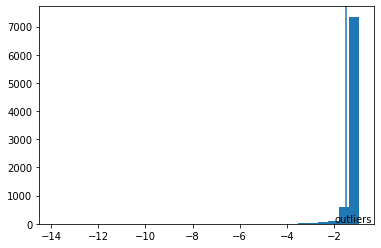

In [62]:
plt.hist(clf.negative_outlier_factor_, bins=30)
plt.axvline(-1.5)
plt.text(-2, 60, 'outliers')
plt.show()

### Isolation Forest

In [63]:
from sklearn.ensemble import IsolationForest

In [64]:
clf = IsolationForest(n_estimators=10, random_state=0)
clf.fit(X_train)

IsolationForest(behaviour='deprecated', bootstrap=False, contamination='auto',
                max_features=1.0, max_samples='auto', n_estimators=10,
                n_jobs=None, random_state=0, verbose=0, warm_start=False)

In [65]:
outliers = clf.predict(X_test)

In [66]:
np.unique(outliers, return_counts=True)

(array([-1,  1]), array([ 702, 1741], dtype=int64))

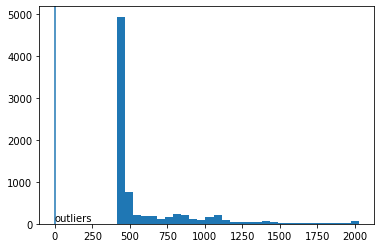

In [67]:
plt.hist(df['CO2'], bins=30)
plt.axvline(-1.5)
plt.text(-2, 60, 'outliers')
plt.show()

### High dimensional approach

In [10]:
from pyod.models.abod import ABOD
from pyod.models.knn import KNN
from pyod.models.lof import LOF
from pyod.models.loci import LOCI
from pyod.models.auto_encoder import AutoEncoder

Using TensorFlow backend.
C:\Users\monia\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\monia\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\monia\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\monia\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py

In [36]:
clf = ABOD(contamination=0.1)
clf.fit(X_train)

C:\Users\monia\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
C:\Users\monia\anaconda3\lib\site-packages\numpy\core\_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
C:\Users\monia\anaconda3\lib\site-packages\numpy\core\_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\monia\anaconda3\lib\site-packages\pyod\models\base.py:365: RuntimeWarning: invalid value encountered in greater
  self.labels_ = (self.decision_scores_ > self.threshold_).astype(


ABOD(contamination=0.1, method='fast', n_neighbors=5)

In [37]:
clf.decision_scores_

array([-1.07193354e+01, -8.62673326e+04, -2.50914078e+03, ...,
       -5.12300016e-03, -5.12810928e+00, -0.00000000e+00])

In [38]:
max(clf.decision_scores_) #più che grande decision score, piu il valore è anormale

-0.0

In [49]:
print(((clf.decision_scores_)<-12000).sum())

236


C:\Users\monia\anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in less
  """Entry point for launching an IPython kernel.


In [72]:
outliers = clf.predict(X_test)
np.unique(outliers, return_counts=True)

C:\Users\monia\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
C:\Users\monia\anaconda3\lib\site-packages\numpy\core\_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
C:\Users\monia\anaconda3\lib\site-packages\numpy\core\_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\monia\anaconda3\lib\site-packages\pyod\models\base.py:168: RuntimeWarning: invalid value encountered in greater
  return (pred_score > self.threshold_).astype('int').ravel()


(array([0]), array([2443], dtype=int64))

C:\Users\monia\anaconda3\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\monia\anaconda3\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


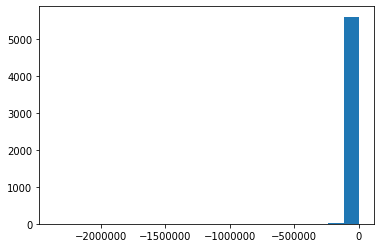

In [73]:
plt.hist(clf.decision_scores_, bins=20)
plt.axvline(np.min(clf.decision_scores_))
plt.show()

## KNN

In [67]:
clf = KNN(contamination=0.01)
clf.fit(X_train)

KNN(algorithm='auto', contamination=0.01, leaf_size=30, method='largest',
  metric='minkowski', metric_params=None, n_jobs=1, n_neighbors=5, p=2,
  radius=1.0)

In [68]:
clf.decision_scores_

array([0.78477881, 0.09      , 0.50249378, ..., 6.03451116, 0.79755879,
       0.03333333])

In [69]:
anomaly_score = clf.decision_function(X_test) #negative values are outliers

In [72]:
min(anomaly_score)

0.0

In [70]:
outliers = clf.predict(X_test)
np.unique(outliers, return_counts=True)

(array([0, 1]), array([2413,   30], dtype=int64))

In [71]:
# no of errors in test set
n_errors = (outliers != y_test).sum()
print('No of Errors in test set: {}'.format(n_errors))
#accuracy in test set
print('Accuracy in test set: {}'.format((accuracy_score(y_test, outliers))))

No of Errors in test set: 523
Accuracy in test set: 0.7859189521080638


## LOF

### Autoencoder

In [7]:
from pyod.models.auto_encoder import AutoEncoder

Using TensorFlow backend.
C:\Users\monia\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\monia\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\monia\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\monia\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py

In [8]:
contamination = 0.1 
epochs = 50

In [9]:
X_train.shape

(5700, 5)

In [10]:
from sklearn.preprocessing import StandardScaler
X_train = StandardScaler().fit_transform(X_train)
X_train = pd.DataFrame(X_train)
X_test = StandardScaler().fit_transform(X_test)
X_test = pd.DataFrame(X_test)

In [11]:
clf = AutoEncoder(hidden_neurons =[5,1,1,5], contamination =contamination, epochs =epochs )
clf.fit(X_train)

Instructions for updating:
Colocations handled automatically by placer.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 5)                 30        
_________________________________________________________________
dropout_1 (Dropout)          (None, 5)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 30        
_________________________________________________________________
dropout_2 (Dropout)          (None, 5)                 0         
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 30        
_________________________________________________________________
dropout_3 (Dropout)          (None, 5)                 0         
________________________________________________

C:\Users\monia\anaconda3\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.106029). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


5130/5130 [==============================] - 1s 267us/step - loss: 2.0954 - val_loss: 2.0104
Epoch 9/50
5130/5130 [==============================] - 1s 165us/step - loss: 1.9515 - val_loss: 1.8791
Epoch 10/50
5130/5130 [==============================] - 1s 165us/step - loss: 1.8264 - val_loss: 1.7730
Epoch 11/50
5130/5130 [==============================] - 1s 140us/step - loss: 1.7189 - val_loss: 1.6853
Epoch 12/50
5130/5130 [==============================] - 1s 122us/step - loss: 1.6387 - val_loss: 1.6112
Epoch 13/50
5130/5130 [==============================] - 1s 165us/step - loss: 1.5644 - val_loss: 1.5472
Epoch 14/50
5130/5130 [==============================] - 1s 154us/step - loss: 1.5033 - val_loss: 1.4915
Epoch 15/50
5130/5130 [==============================] - 1s 163us/step - loss: 1.4507 - val_loss: 1.4432
Epoch 16/50
5130/5130 [==============================] - 1s 156us/step - loss: 1.4020 - val_loss: 1.4001
Epoch 17/50
5130/5130 [==============================] - 1s 173us/st

AutoEncoder(batch_size=32, contamination=0.1, dropout_rate=0.2, epochs=50,
      hidden_activation='relu', hidden_neurons=[5, 1, 1, 5],
      l2_regularizer=0.1,
      loss=<function mean_squared_error at 0x0000021C41558708>,
      optimizer='adam', output_activation='sigmoid', preprocessing=True,
      random_state=None, validation_size=0.1, verbose=1)

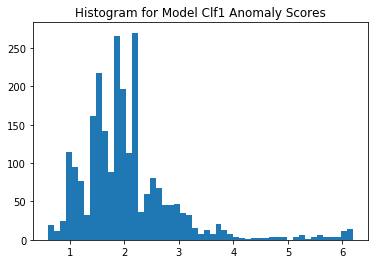

In [12]:
# Get the outlier scores for the train data
y_train_scores = clf.decision_scores_  

# Predict the anomaly scores
y_test_scores = clf.decision_function(X_test)  # outlier scores
y_test_scores = pd.Series(y_test_scores)

# Plot it!
import matplotlib.pyplot as plt
plt.hist(y_test_scores, bins='auto')  
plt.title("Histogram for Model Clf1 Anomaly Scores")
plt.show()

The following output shows the mean variable values in each cluster. The values of Cluster ‘1’ (the abnormal cluster) is quite different from those of Cluster ‘0’ (the normal cluster). The “score” values show the average distance of those observations to others. A high “score” means that observation is far away from the norm.

In [13]:
df_test = X_test.copy()
df_test['score'] = y_test_scores
df_test['cluster'] = np.where(df_test['score']<4, 0, 1)
df_test['cluster'].value_counts()

df_test.groupby('cluster').mean()

,0,1,2,3,4,score
cluster,,,,,,
0,-0.044494,-0.073875,-0.042331,-0.128720,-0.092487,1.939276
1,1.297470,2.154218,1.234382,3.753549,2.696976,5.415274


In [14]:
outliers = clf.predict(X)
np.unique(outliers, return_counts=True)

(array([1]), array([8143], dtype=int64))